#1、Uniform data unit format

  data->df

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from google.colab import drive

# 挂载Google Drive
drive.mount('/content/drive')
#指定某些列的数据类型为文本
data = pd.read_excel('/content/drive/My Drive/P2 code/original_data.xlsx',dtype={'Stock_Code': str})
data.head()

Mounted at /content/drive


Date Stock_Code Stock_Name  Closing_Price_Yuan Price_Change_Percent  \
0  2024-01-02     688525       佰维存储               50.13               -20.00   
1  2024-01-02     688010       福光股份               27.48                14.21   
2  2024-01-02     688385       复旦微电               37.60                -2.67   
3  2024-01-02     688041       海光信息               72.36                 1.94   
4  2024-01-02     688609       九联科技               13.33                 0.98   

  Margin_Balance Balance_to_Circulating_MV_Percent Margin_Purchase_Amount  \
0          2.45亿                             1.95%                  1.27亿   
1          1.54亿                             3.49%                  4983万   
2          5.61亿                             4.68%                  4769万   
3         18.27亿                             2.85%                  1.43亿   
4          4.12亿                             9.41%                  1.16亿   

  Margin_Repurchased_Amount Margin_Net_Purchase_Amount Short_Selling_Balance  \
0                     4221万                      8507万                 8419万   
1                     1101万                      3882万                41.60万   
2                     1404万                      3365万                 5310万   
3                     1.13亿                      2984万                11.50亿   
4                     8668万                      2935万                 3113万   

  Short_Selling_Volume Short_Selling_Sold_Volume  \
0               167.9万                    13.35万   
1                1.51万                     200.0   
2               141.2万                     4.20万   
3                1589万                    27.22万   
4               233.5万                    70.92万   

  Short_Selling_Repurchased_Volume Short_Selling_Net_Sold_Volume  \
0                           72.78万                       -59.44万   
1                            300.0                        -100.0   
2                            4.86万                         -6650   
3                           35.53万                        -8.31万   
4                           82.38万                       -11.46万   

  Margin_and_Short_Balance Margin_and_Short_Balance_Change  
0                    3.30亿                           1.61亿  
1                    1.54亿                           1.53亿  
2                    6.14亿                           5.07亿  
3                   29.77亿                           6.77亿  
4                    4.43亿                           3.81亿

In [ ]:
data.isnull().sum()

Date                                  0
Stock_Code                           10
Stock_Name                           10
Closing_Price_Yuan                   10
Price_Change_Percent                 10
Margin_Balance                       10
Balance_to_Circulating_MV_Percent    10
Margin_Purchase_Amount               10
Margin_Repurchased_Amount            10
Margin_Net_Purchase_Amount           10
Short_Selling_Balance                10
Short_Selling_Volume                 10
Short_Selling_Sold_Volume            10
Short_Selling_Repurchased_Volume     10
Short_Selling_Net_Sold_Volume        10
Margin_and_Short_Balance             10
Margin_and_Short_Balance_Change      10
dtype: int64

In [ ]:
#处理缺失值
df = data.dropna(subset=['Stock_Name'])
df.isnull().sum()

Date                                 0
Stock_Code                           0
Stock_Name                           0
Closing_Price_Yuan                   0
Price_Change_Percent                 0
Margin_Balance                       0
Balance_to_Circulating_MV_Percent    0
Margin_Purchase_Amount               0
Margin_Repurchased_Amount            0
Margin_Net_Purchase_Amount           0
Short_Selling_Balance                0
Short_Selling_Volume                 0
Short_Selling_Sold_Volume            0
Short_Selling_Repurchased_Volume     0
Short_Selling_Net_Sold_Volume        0
Margin_and_Short_Balance             0
Margin_and_Short_Balance_Change      0
dtype: int64

In [ ]:
# 修改数据转换函数以处理非数字字符串
def convert_currency(val):
    if isinstance(val, str):
        val = val.replace(',', '')  # Remove commas
        if '亿' in val:
            val = float(val.replace('亿', '')) * 1e8
        elif '万' in val:
            val = float(val.replace('万', '')) * 1e4
        elif val.strip() == '-':  # Handle standalone '-' as NaN
            val = 0.0
        else:
            try:
                val = float(val)
            except ValueError:
                val = 0.0
    return val

# 转换数字字符串列为浮点数（元）
currency_columns = ['Margin_Balance','Margin_Purchase_Amount','Margin_Repurchased_Amount','Margin_Net_Purchase_Amount','Short_Selling_Balance','Short_Selling_Volume',
            'Short_Selling_Sold_Volume','Short_Selling_Repurchased_Volume','Short_Selling_Net_Sold_Volume','Margin_and_Short_Balance','Margin_and_Short_Balance_Change']
for col in currency_columns:
    df[col] = df[col].apply(convert_currency)

# 将特定列从元转换为万元
for col in currency_columns:
    df[col] = df[col] / 1e4

def convert_percentage(val):
    if isinstance(val, str):
        val = val.strip()
        if '%' in val:
            try:
                return float(val.replace('%', '')) / 100
            except ValueError:
                return np.nan
        elif val.strip() == '-':  # Handle standalone '-' as NaN
            return 0.0
        else:
            try:
                return float(val)
            except ValueError:
                return 0.0
    return val

# Apply conversion to percentage columns
percentage_columns = ['Price_Change_Percent', 'Balance_to_Circulating_MV_Percent']
for col in percentage_columns:
    df[col] = df[col].apply(convert_percentage)

# Ensure conversion to float
df['Price_Change_Percent'] = pd.to_numeric(df['Price_Change_Percent'], errors='coerce')
df['Balance_to_Circulating_MV_Percent'] = pd.to_numeric(df['Balance_to_Circulating_MV_Percent'], errors='coerce')

# 将 '交易日期' 列转换为 datetime 类型
df['Date'] = pd.to_datetime(df['Date'])

# 检查处理后的数据头部
df.head()

<ipython-input-4-ad1318c22fd1>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(convert_currency)
<ipython-input-4-ad1318c22fd1>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col] / 1e4
<ipython-input-4-ad1318c22fd1>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

Date Stock_Code Stock_Name  Closing_Price_Yuan  Price_Change_Percent  \
0 2024-01-02     688525       佰维存储               50.13                -20.00   
1 2024-01-02     688010       福光股份               27.48                 14.21   
2 2024-01-02     688385       复旦微电               37.60                 -2.67   
3 2024-01-02     688041       海光信息               72.36                  1.94   
4 2024-01-02     688609       九联科技               13.33                  0.98   

   Margin_Balance  Balance_to_Circulating_MV_Percent  Margin_Purchase_Amount  \
0         24500.0                             0.0195                 12700.0   
1         15400.0                             0.0349                  4983.0   
2         56100.0                             0.0468                  4769.0   
3        182700.0                             0.0285                 14300.0   
4         41200.0                             0.0941                 11600.0   

   Margin_Repurchased_Amount  Margin_Net_Purchase_Amount  \
0                     4221.0                      8507.0   
1                     1101.0                      3882.0   
2                     1404.0                      3365.0   
3                    11300.0                      2984.0   
4                     8668.0                      2935.0   

   Short_Selling_Balance  Short_Selling_Volume  Short_Selling_Sold_Volume  \
0                 8419.0                167.90                      13.35   
1                   41.6                  1.51                       0.02   
2                 5310.0                141.20                       4.20   
3               115000.0               1589.00                      27.22   
4                 3113.0                233.50                      70.92   

   Short_Selling_Repurchased_Volume  Short_Selling_Net_Sold_Volume  \
0                             72.78                        -59.440   
1                              0.03                         -0.010   
2                              4.86                         -0.665   
3                             35.53                         -8.310   
4                             82.38                        -11.460   

   Margin_and_Short_Balance  Margin_and_Short_Balance_Change  
0                   33000.0                          16100.0  
1                   15400.0                          15300.0  
2                   61400.0                          50700.0  
3                  297700.0                          67700.0  
4                   44300.0                          38100.0

In [ ]:
# 重命名货币列为万元
currency_columns_wan = {col: col + '_10K_Yuan' for col in currency_columns}
currency_columns_wan.update({col: col + '_10K_Shares' for col in ['Short_Selling_Volume','Short_Selling_Sold_Volume','Short_Selling_Repurchased_Volume','Short_Selling_Net_Sold_Volume']})
df.rename(columns=currency_columns_wan, inplace=True)

# 检查处理后的数据头部
df.head()

<ipython-input-5-acd8db0dd23a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=currency_columns_wan, inplace=True)


Date Stock_Code Stock_Name  Closing_Price_Yuan  Price_Change_Percent  \
0 2024-01-02     688525       佰维存储               50.13                -20.00   
1 2024-01-02     688010       福光股份               27.48                 14.21   
2 2024-01-02     688385       复旦微电               37.60                 -2.67   
3 2024-01-02     688041       海光信息               72.36                  1.94   
4 2024-01-02     688609       九联科技               13.33                  0.98   

   Margin_Balance_10K_Yuan  Balance_to_Circulating_MV_Percent  \
0                  24500.0                             0.0195   
1                  15400.0                             0.0349   
2                  56100.0                             0.0468   
3                 182700.0                             0.0285   
4                  41200.0                             0.0941   

   Margin_Purchase_Amount_10K_Yuan  Margin_Repurchased_Amount_10K_Yuan  \
0                          12700.0                              4221.0   
1                           4983.0                              1101.0   
2                           4769.0                              1404.0   
3                          14300.0                             11300.0   
4                          11600.0                              8668.0   

   Margin_Net_Purchase_Amount_10K_Yuan  Short_Selling_Balance_10K_Yuan  \
0                               8507.0                          8419.0   
1                               3882.0                            41.6   
2                               3365.0                          5310.0   
3                               2984.0                        115000.0   
4                               2935.0                          3113.0   

   Short_Selling_Volume_10K_Shares  Short_Selling_Sold_Volume_10K_Shares  \
0                           167.90                                 13.35   
1                             1.51                                  0.02   
2                           141.20                                  4.20   
3                          1589.00                                 27.22   
4                           233.50                                 70.92   

   Short_Selling_Repurchased_Volume_10K_Shares  \
0                                        72.78   
1                                         0.03   
2                                         4.86   
3                                        35.53   
4                                        82.38   

   Short_Selling_Net_Sold_Volume_10K_Shares  \
0                                   -59.440   
1                                    -0.010   
2                                    -0.665   
3                                    -8.310   
4                                   -11.460   

   Margin_and_Short_Balance_10K_Yuan  Margin_and_Short_Balance_Change_10K_Yuan  
0                            33000.0                                   16100.0  
1                            15400.0                                   15300.0  
2                            61400.0                                   50700.0  
3                           297700.0                                   67700.0  
4                            44300.0                                   38100.0

In [ ]:
print("Data Info:")
df.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 32845 entries, 0 to 32852
Data columns (total 17 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   Date                                         32845 non-null  datetime64[ns]
 1   Stock_Code                                   32845 non-null  object        
 2   Stock_Name                                   32845 non-null  object        
 3   Closing_Price_Yuan                           32845 non-null  float64       
 4   Price_Change_Percent                         32845 non-null  float64       
 5   Margin_Balance_10K_Yuan                      32845 non-null  float64       
 6   Balance_to_Circulating_MV_Percent            32845 non-null  float64       
 7   Margin_Purchase_Amount_10K_Yuan              32845 non-null  float64       
 8   Margin_Repurchased_Amount_10K_Yuan           32845 non-null  float64  

In [ ]:
#导出数据查看是否还存在缺失值（查看process_data.xlsx）
output_file_path = '/content/drive/My Drive/P2 code/process_data.xlsx'
df.to_excel(output_file_path, index=False)

#2、Preliminary abnormal analysis
Directly read the process_data.xlsx file

df->pro_data

In [ ]:
# 挂载Google Drive
from google.colab import drive
drive.mount('/content/drive')
#指定某些列的数据类型为文本
import pandas as pd
pro_data = pd.read_excel('/content/drive/My Drive/P2 code/process_data.xlsx',dtype={'Stock_Code': str})
pro_data.head()

Mounted at /content/drive


Date Stock_Code Stock_Name  Closing_Price_Yuan  Price_Change_Percent  \
0 2024-01-02     688525       佰维存储               50.13                -20.00   
1 2024-01-02     688010       福光股份               27.48                 14.21   
2 2024-01-02     688385       复旦微电               37.60                 -2.67   
3 2024-01-02     688041       海光信息               72.36                  1.94   
4 2024-01-02     688609       九联科技               13.33                  0.98   

   Margin_Balance_10K_Yuan  Balance_to_Circulating_MV_Percent  \
0                  24500.0                             0.0195   
1                  15400.0                             0.0349   
2                  56100.0                             0.0468   
3                 182700.0                             0.0285   
4                  41200.0                             0.0941   

   Margin_Purchase_Amount_10K_Yuan  Margin_Repurchased_Amount_10K_Yuan  \
0                          12700.0                              4221.0   
1                           4983.0                              1101.0   
2                           4769.0                              1404.0   
3                          14300.0                             11300.0   
4                          11600.0                              8668.0   

   Margin_Net_Purchase_Amount_10K_Yuan  Short_Selling_Balance_10K_Yuan  \
0                               8507.0                          8419.0   
1                               3882.0                            41.6   
2                               3365.0                          5310.0   
3                               2984.0                        115000.0   
4                               2935.0                          3113.0   

   Short_Selling_Volume_10K_Shares  Short_Selling_Sold_Volume_10K_Shares  \
0                           167.90                                 13.35   
1                             1.51                                  0.02   
2                           141.20                                  4.20   
3                          1589.00                                 27.22   
4                           233.50                                 70.92   

   Short_Selling_Repurchased_Volume_10K_Shares  \
0                                        72.78   
1                                         0.03   
2                                         4.86   
3                                        35.53   
4                                        82.38   

   Short_Selling_Net_Sold_Volume_10K_Shares  \
0                                   -59.440   
1                                    -0.010   
2                                    -0.665   
3                                    -8.310   
4                                   -11.460   

   Margin_and_Short_Balance_10K_Yuan  Margin_and_Short_Balance_Change_10K_Yuan  
0                            33000.0                                   16100.0  
1                            15400.0                                   15300.0  
2                            61400.0                                   50700.0  
3                           297700.0                                   67700.0  
4                            44300.0                                   38100.0

In [ ]:
print("Data Info:")
pro_data.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32845 entries, 0 to 32844
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   交易日期         32845 non-null  datetime64[ns]
 1   证券代码         32845 non-null  object        
 2   证券简称         32845 non-null  object        
 3   收盘价_元        32845 non-null  float64       
 4   涨跌幅_%        32845 non-null  float64       
 5   融资余额_万元      32845 non-null  float64       
 6   余额占流通市值比_%   32845 non-null  float64       
 7   融资买入额_万元     32845 non-null  float64       
 8   融资偿还额_万元     32845 non-null  float64       
 9   融资净买入_万元     32845 non-null  float64       
 10  融券余额_万元      32845 non-null  float64       
 11  融券余量_万股      32845 non-null  float64       
 12  融券卖出量_万股     32845 non-null  float64       
 13  融券偿还量_万股     32845 non-null  float64       
 14  融券净卖出_万股     32845 non-null  float64       
 15  融资融券余额_万元    32845 non-null  float64      

###2.1 3-sigma method

Preliminary threshold anomaly detection using the 3-sigma method: suitable as a default rule for data preprocessing.

In [ ]:
import sys

import pandas as pd
from tqdm import tqdm


if __name__ == "__main__":
    data =pro_data  # 读取数据

    for col in [
        "Margin_Balance_10K_Yuan",
        "Margin_Purchase_Amount_10K_Yuan",
        "Margin_Repurchased_Amount_10K_Yuan",
        "Margin_Net_Purchase_Amount_10K_Yuan",
        "Short_Selling_Balance_10K_Yuan",
        "Short_Selling_Volume_10K_Shares",
        "Short_Selling_Sold_Volume_10K_Shares",
        "Short_Selling_Repurchased_Volume_10K_Shares",
        "Short_Selling_Net_Sold_Volume_10K_Shares",
        "Margin_and_Short_Balance_10K_Yuan",
        "Margin_and_Short_Balance_Change_10K_Yuan"
    ]:  # 遍历所有需要转换的列
        data[col] = data[col].astype(int)  # 将数据转换为整数

    data_cols = data.columns.tolist()  # 获取所有列名

    threshold_manually = {
        "Closing_Price_Yuan": "3-sigma",
        "Price_Change_Percent": "3-sigma",
        "Margin_Balance_10K_Yuan": "3-sigma",
        "Balance_to_Circulating_MV_Percent": "3-sigma",
        "Margin_Purchase_Amount_10K_Yuan": "3-sigma",
        "Margin_Repurchased_Amount_10K_Yuan": "3-sigma",
        "Margin_Net_Purchase_Amount_10K_Yuan": "3-sigma",
        "Short_Selling_Balance_10K_Yuan": "3-sigma",
        "Short_Selling_Volume_10K_Shares": "3-sigma",
        "Short_Selling_Sold_Volume_10K_Shares": "3-sigma",
        "Short_Selling_Repurchased_Volume_10K_Shares": "3-sigma",
        "Short_Selling_Net_Sold_Volume_10K_Shares": "3-sigma",
        "Margin_and_Short_Balance_10K_Yuan": "3-sigma",
        "Margin_and_Short_Balance_Change_10K_Yuan": "3-sigma"
        #"Margin_Balance_10K_Yuan": (-500000000, 8000000000) 尝试根据业务规则设置手动阈值
    }
    results = []  # 保存结果
    all_coda_data = sorted(data.groupby(by="Stock_Code"), key=lambda x: x[0], reverse=False)  # 按证券代码分组
    for coda_idx, (coda_id, code_data) in enumerate(tqdm(all_coda_data, file=sys.stdout)):  # 遍历所有证券代码
        code_data = code_data.sort_values(by="Date", ascending=True).reset_index(drop=True)  # 按日期排序

        threshold = {}  # 保存阈值
        for col in [
            "Closing_Price_Yuan",
            "Price_Change_Percent",
            "Margin_Balance_10K_Yuan",
            "Balance_to_Circulating_MV_Percent",
            "Margin_Purchase_Amount_10K_Yuan",
            "Margin_Repurchased_Amount_10K_Yuan",
            "Margin_Net_Purchase_Amount_10K_Yuan",
            "Short_Selling_Balance_10K_Yuan",
            "Short_Selling_Volume_10K_Shares",
            "Short_Selling_Sold_Volume_10K_Shares",
            "Short_Selling_Repurchased_Volume_10K_Shares",
            "Short_Selling_Net_Sold_Volume_10K_Shares",
            "Margin_and_Short_Balance_10K_Yuan",
            "Margin_and_Short_Balance_Change_10K_Yuan"
        ]:  # 遍历所有列
            if threshold_manually[col] == "3-sigma":  # 3-sigma
                min_value = data[col].values.mean().item() - 3 * data[col].values.std().item()  # 3-sigma最小值
                max_value = data[col].values.mean().item() + 3 * data[col].values.std().item()  # 3-sigma最大值
                threshold[col] = (min_value, max_value)  # 保存阈值
            else:  # 手动设置
                threshold[col] = threshold_manually[col]  # 保存阈值

        for col in [
            "Closing_Price_Yuan",
            "Price_Change_Percent",
            "Margin_Balance_10K_Yuan",
            "Balance_to_Circulating_MV_Percent",
            "Margin_Purchase_Amount_10K_Yuan",
            "Margin_Repurchased_Amount_10K_Yuan",
            "Margin_Net_Purchase_Amount_10K_Yuan",
            "Short_Selling_Balance_10K_Yuan",
            "Short_Selling_Volume_10K_Shares",
            "Short_Selling_Sold_Volume_10K_Shares",
            "Short_Selling_Repurchased_Volume_10K_Shares",
            "Short_Selling_Net_Sold_Volume_10K_Shares",
            "Margin_and_Short_Balance_10K_Yuan",
            "Margin_and_Short_Balance_Change_10K_Yuan"
        ]:  # 遍历所有列
            code_data[f"{col}_anomaly"] = code_data[col].apply(
                lambda x: 0 if threshold[col][0] <= x <= threshold[col][1] else 1
            )  # 标记异常值

        code_data["anomaly"] = code_data[[col for col in code_data.columns.tolist() if "anomaly" in col]].sum(
            axis=1
        )  # 计算异常值数量
        code_data["anomaly"] = code_data["anomaly"].apply(lambda x: 1 if x > 0 else 0)  # 标记异常值

        results.append(code_data[data_cols + ["anomaly"]])  # 保存结果

    results = pd.concat(results, axis=0)  # 合并结果
    results = results.sort_values(by=["Stock_Code", "Date"], ascending=True).reset_index(
        drop=True
    )  # 按证券代码和日期排序
    print(results)  # 打印结果
    results.to_excel("/content/drive/My Drive/P2 code/data_results.xlsx", index=False)  # 保存结果

100%|██████████| 568/568 [00:11<00:00, 48.91it/s]
            Date Stock_Code Stock_Name  Closing_Price_Yuan  \
0     2024-01-02     688001       华兴源创               34.72   
1     2024-01-03     688001       华兴源创               32.24   
2     2024-01-04     688001       华兴源创               31.76   
3     2024-01-05     688001       华兴源创               31.20   
4     2024-01-08     688001       华兴源创               29.66   
...          ...        ...        ...                 ...   
32840 2024-03-25     689009       九号公司               30.57   
32841 2024-03-26     689009       九号公司               30.80   
32842 2024-03-27     689009       九号公司               29.45   
32843 2024-03-28     689009       九号公司               29.96   
32844 2024-03-29     689009       九号公司               29.95   

       Price_Change_Percent  Margin_Balance_10K_Yuan  \
0                     -0.66                    14000   
1                     -7.14                    15500   
2                     -1.49          

###2.2 Clustering first, then Isolation Forest

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from tqdm import tqdm

# 定义孤立森林检测函数
def detect_anomalies_with_isolation_forest(data, contamination=0.1):
    model = IsolationForest(contamination=contamination, random_state=42)
    model.fit(data)
    anomaly_flags = model.predict(data)
    return anomaly_flags

if __name__ == "__main__":
    # 读取数据
    prodata = pro_data  # 假设已经加载了原始数据

    # 只选择数值型列用于聚类和异常检测
    numeric_columns = prodata.select_dtypes(include=["float", "int"]).columns.tolist()

    # Step 1: K-means 聚类
    kmeans = KMeans(n_clusters=5, random_state=42)  # 设置分组数
    prodata['cluster'] = kmeans.fit_predict(prodata[numeric_columns])

    # Step 2: 针对每个聚类组，使用孤立森林进行异常检测
    prodata['anomaly'] = 0  # 初始化异常列
    for cluster_id in tqdm(prodata['cluster'].unique(), desc="Processing Clusters"):
        cluster_data = prodata[prodata['cluster'] == cluster_id].copy()
        # 只传递数值型列
        anomaly_flags = detect_anomalies_with_isolation_forest(
            cluster_data[numeric_columns], contamination=0.05
        )
        # 更新对应组的异常标记到原始数据
        prodata.loc[prodata['cluster'] == cluster_id, 'anomaly'] = (anomaly_flags == -1).astype(int)

    # 删除聚类中间列，仅保留原始列和新增的 anomaly 列
    prodata = prodata.drop(columns=['cluster'])

    # 输出最终结果
    print(prodata)
    prodata.to_excel("anomaly_results.xlsx", index=False)


Processing Clusters: 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]


            Date Stock_Code Stock_Name  Closing_Price_Yuan  \
0     2024-01-02     688525       佰维存储               50.13   
1     2024-01-02     688010       福光股份               27.48   
2     2024-01-02     688385       复旦微电               37.60   
3     2024-01-02     688041       海光信息               72.36   
4     2024-01-02     688609       九联科技               13.33   
...          ...        ...        ...                 ...   
32840 2024-03-29     688472        阿特斯               12.42   
32841 2024-03-29     688981       中芯国际               43.66   
32842 2024-03-29     688076       诺泰生物               52.86   
32843 2024-03-29     688088       虹软科技               32.59   
32844 2024-03-29     688525       佰维存储               53.15   

       Price_Change_Percent  Margin_Balance_10K_Yuan  \
0                    -20.00                  24500.0   
1                     14.21                  15400.0   
2                     -2.67                  56100.0   
3                      1.94    

###2.3 Compare results

In [ ]:
prodata_sigma = pd.read_excel('data_results.xlsx',dtype={'Stock_Code': str})
prodata_kmeans = pd.read_excel('anomaly_results.xlsx',dtype={'Stock_Code': str})

In [ ]:
sigma_count = prodata_sigma['anomaly'].sum()
kmeans_count = prodata_kmeans['anomaly'].sum()
diff_percentage = abs(sigma_count - kmeans_count) / max(sigma_count, kmeans_count) * 100
diff_percentage

22.365119196988708

In [ ]:
# 3-sigma 方法检测结果
sigma_anomalies = set(prodata_sigma[prodata_sigma["anomaly"] == 1].index)

# K-means + Isolation Forest 方法检测结果
kmeans_anomalies = set(prodata_kmeans[prodata_kmeans["anomaly"] == 1].index)

# 检查类型
print(f"3-sigma 类型: {type(sigma_anomalies)}")
print(f"K-means 类型: {type(kmeans_anomalies)}")

# 对比分析
common_anomalies = sigma_anomalies & kmeans_anomalies  # 交集
sigma_only = sigma_anomalies - kmeans_anomalies       # 差集
kmeans_only = kmeans_anomalies - sigma_anomalies      # 差集

# 打印统计结果
print(f"3-sigma 方法异常点数量: {len(sigma_anomalies)}")
print(f"K-means + Isolation Forest 方法异常点数量: {len(kmeans_anomalies)}")
print(f"两种方法共同检测到的异常点数量: {len(common_anomalies)}")
print(f"仅 3-sigma 方法检测到的异常点数量: {len(sigma_only)}")
print(f"仅 K-means + Isolation Forest 方法检测到的异常点数量: {len(kmeans_only)}")


3-sigma 类型: <class 'set'>
K-means 类型: <class 'set'>
3-sigma 方法异常点数量: 3188
K-means + Isolation Forest 方法异常点数量: 2475
两种方法共同检测到的异常点数量: 2416
仅 3-sigma 方法检测到的异常点数量: 772
仅 K-means + Isolation Forest 方法检测到的异常点数量: 59


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume prodata_sigma and prodata_kmeans contain 'anomaly' column with 1 indicating anomalies

# Define anomaly sets
sigma_anomalies = set(prodata_sigma[prodata_sigma["anomaly"] == 1].index)
kmeans_anomalies = set(prodata_kmeans[prodata_kmeans["anomaly"] == 1].index)

# Compare anomalies
common_anomalies = sigma_anomalies & kmeans_anomalies  # Intersection
sigma_only = sigma_anomalies - kmeans_anomalies       # Unique to 3-sigma
kmeans_only = kmeans_anomalies - sigma_anomalies      # Unique to K-means + Isolation Forest

# 1. Total anomalies
print(f"Total anomalies detected by 3-sigma: {len(sigma_anomalies)}")
print(f"Total anomalies detected by K-means + Isolation Forest: {len(kmeans_anomalies)}")

print(f"两种方法共同检测到的异常点数量: {len(common_anomalies)}")

# 2. Intersection ratio (%)
intersection_ratio = (len(common_anomalies) / min(len(sigma_anomalies), len(kmeans_anomalies))) * 100
print(f"Intersection ratio of anomalies: {intersection_ratio:.2f}%")



Total anomalies detected by 3-sigma: 3188
Total anomalies detected by K-means + Isolation Forest: 2475
Intersection ratio of anomalies: 97.62%
Anomalies unique to 3-sigma: 24.22%
Anomalies unique to K-means + Isolation Forest: 2.38%


# 3、Perform EDA analysis on data sets containing abnormal labels
Read the data_results.xlsx file directly

pro_data->fx_data

In [ ]:
# 挂载Google Drive
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
fx_data = pd.read_excel('/content/drive/My Drive/P2 code/data_results.xlsx',dtype={'Stock_Code': str})
fx_data.head()

Mounted at /content/drive


Date Stock_Code Stock_Name  Closing_Price_Yuan  Price_Change_Percent  \
0 2024-01-02     688001       华兴源创               34.72                 -0.66   
1 2024-01-03     688001       华兴源创               32.24                 -7.14   
2 2024-01-04     688001       华兴源创               31.76                 -1.49   
3 2024-01-05     688001       华兴源创               31.20                 -1.76   
4 2024-01-08     688001       华兴源创               29.66                 -4.94   

   Margin_Balance_10K_Yuan  Balance_to_Circulating_MV_Percent  \
0                    14000                             0.0091   
1                    15500                             0.0109   
2                    15800                             0.0112   
3                    15300                             0.0111   
4                    15100                             0.0115   

   Margin_Purchase_Amount_10K_Yuan  Margin_Repurchased_Amount_10K_Yuan  \
0                             1338                                 718   
1                             2355                                 826   
2                              911                                 669   
3                              417                                 853   
4                              347                                 605   

   Margin_Net_Purchase_Amount_10K_Yuan  Short_Selling_Balance_10K_Yuan  \
0                                  619                            2853   
1                                 1529                            2705   
2                                  241                            2633   
3                                 -435                            2573   
4                                 -258                            2445   

   Short_Selling_Volume_10K_Shares  Short_Selling_Sold_Volume_10K_Shares  \
0                               82                                     2   
1                               83                                     4   
2                               82                                     2   
3                               82                                     2   
4                               82                                     2   

   Short_Selling_Repurchased_Volume_10K_Shares  \
0                                            4   
1                                            2   
2                                            3   
3                                            2   
4                                            2   

   Short_Selling_Net_Sold_Volume_10K_Shares  \
0                                        -1   
1                                         1   
2                                         0   
3                                         0   
4                                         0   

   Margin_and_Short_Balance_10K_Yuan  \
0                              16900   
1                              18200   
2                              18400   
3                              17900   
4                              17500   

   Margin_and_Short_Balance_Change_10K_Yuan  anomaly  
0                                     11200        0  
1                                     12800        0  
2                                     13100        0  
3                                     12800        0  
4                                     12600        0

In [ ]:
fx_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32845 entries, 0 to 32844
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   Date                                         32845 non-null  datetime64[ns]
 1   Stock_Code                                   32845 non-null  object        
 2   Stock_Name                                   32845 non-null  object        
 3   Closing_Price_Yuan                           32845 non-null  float64       
 4   Price_Change_Percent                         32845 non-null  float64       
 5   Margin_Balance_10K_Yuan                      32845 non-null  int64         
 6   Balance_to_Circulating_MV_Percent            32845 non-null  float64       
 7   Margin_Purchase_Amount_10K_Yuan              32845 non-null  int64         
 8   Margin_Repurchased_Amount_10K_Yuan           32845 non-null  int64         


###3.1Univariate distribution analysis

In [ ]:
# Check the distribution of the target variable 'anomaly' 异常标签分布
import matplotlib.pyplot as plt
import plotly.express as px

anomaly_distribution = fx_data['anomaly'].value_counts()

# 绘制异常分布
fig = px.bar(
    x=anomaly_distribution.index,
    y=anomaly_distribution.values,
    labels={'x': 'Anomaly', 'y': 'Count'},
    title='Distribution of Anomaly Labels',
    text=anomaly_distribution.values.astype(str),
)
fig.show()

In [ ]:
# 单变量分析
#后面eda分析都会用到这个numerical_columns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

numerical_columns = [
    "Closing_Price_Yuan","Price_Change_Percent","Margin_Balance_10K_Yuan","Balance_to_Circulating_MV_Percent","Margin_Purchase_Amount_10K_Yuan","Margin_Repurchased_Amount_10K_Yuan",
    "Margin_Net_Purchase_Amount_10K_Yuan","Short_Selling_Balance_10K_Yuan","Short_Selling_Volume_10K_Shares","Short_Selling_Sold_Volume_10K_Shares","Short_Selling_Repurchased_Volume_10K_Shares",
    "Short_Selling_Net_Sold_Volume_10K_Shares","Margin_and_Short_Balance_10K_Yuan","Margin_and_Short_Balance_Change_10K_Yuan"
]

# 创建子图：每行两列（直方图 + 箱线图）
fig = make_subplots(
    rows=len(numerical_columns), cols=2,
    subplot_titles=[f"{numerical_columns[i//2]} - Histogram" if i % 2 == 0 else f"{numerical_columns[i//2]} - Boxplot"
        for i in range(2 * len(numerical_columns))],
    vertical_spacing=0.05,
    horizontal_spacing=0.1
)

# 循环绘制图表
for i, col in enumerate(numerical_columns):
    # 直方图
    fig.add_trace(
        go.Histogram(
            x=fx_data[col].dropna(),
            nbinsx=30,
            marker=dict(color='blue', line=dict(color='black', width=1)),
            opacity=0.7
        ),
        row=i + 1, col=1
    )

    # 箱线图
    fig.add_trace(
        go.Box(
            x=fx_data[col].dropna(),
            boxpoints='outliers',
            marker=dict(color='orange'),
            line=dict(color='black')
        ),
        row=i + 1, col=2
    )

# 更新布局
fig.update_layout(
    height=80 * len(numerical_columns),  # 动态调整高度
    width=1200,
    title_text="Single Variable Analysis: Histograms and Boxplots",
    showlegend=False
)

# 显示图表
fig.show()

结果分析：

异常值检测：某些变量（如“涨跌幅_%”、“融资净买入_万元”）的异常值值得进一步分析，可能与“anomaly”标签相关。

数据标准化：部分变量分布偏态严重（如融资余额），可以考虑进行数据标准化，以便后续模型更稳定。

变量选择：对于分布较为均匀、范围广的变量（如“余额占流通市值比_%”），可能在分类问题中具有较大贡献。

###3.2 Analysis of relationships between variables

In [ ]:
import plotly.express as px
import pandas as pd

# 计算相关矩阵
correlation_matrix = fx_data[numerical_columns].corr()

# 绘制热力图
fig = px.imshow(
    correlation_matrix,
    text_auto=True,
    color_continuous_scale="RdBu",  # 替换为 Plotly 支持的 colorscale
    labels={"color": "Correlation"},
    title="Correlation Matrix of Variables"
)
fig.update_layout(
    xaxis=dict(tickangle=45,tickfont=dict(size=10)),
    yaxis=dict(tickangle=0,tickfont=dict(size=10)),
    title_x=0.5
)
fig.show()

In [ ]:
pairs_to_plot = [
    ("Margin_Balance_10K_Yuan","Balance_to_Circulating_MV_Percent"),
    ("Margin_Purchase_Amount_10K_Yuan","Margin_Net_Purchase_Amount_10K_Yuan"),
    ("Short_Selling_Sold_Volume_10K_Shares","Short_Selling_Net_Sold_Volume_10K_Shares"),
    ("Short_Selling_Balance_10K_Yuan","Short_Selling_Volume_10K_Shares")
]

# 绘制多个散点图（2个变量间关系）
for x_var, y_var in pairs_to_plot:
    fig = px.scatter(
        fx_data,
        x=x_var,
        y=y_var,
        title=f"Scatter Plot: {x_var} vs {y_var}",
        labels={x_var: x_var, y_var: y_var},
        opacity=0.6
    )
    fig.update_traces(marker=dict(size=8, line=dict(width=1, color='DarkSlateGrey')))
    fig.show()

In [ ]:
# 绘制气泡图（三者之间的关系）
fx_data["Margin_Net_Purchase_Amount_10K_Yuan_abs"] = fx_data["Margin_Net_Purchase_Amount_10K_Yuan"].abs()

# 动态设置颜色列（不修改原始数据）
temp_fx_data = fx_data.copy()
temp_fx_data["Bubble Color"] = fx_data["Margin_Net_Purchase_Amount_10K_Yuan"].apply(lambda x: "red" if x < 0 else "blue")

# 创建气泡图
fig = px.scatter(
    temp_fx_data,
    x="Margin_Purchase_Amount_10K_Yuan",  # X轴
    y="Margin_Repurchased_Amount_10K_Yuan",  # Y轴
    size="Margin_Net_Purchase_Amount_10K_Yuan_abs",  # 气泡大小 (绝对值)
    color="Bubble Color",  # 气泡颜色
    title="Bubble Plot: Margin_Purchase_Amount(10K_Yuan) vs Margin_Repurchased_Amount(10K_Yuan) (Bubble Size: Margin_Net_Purchase_Amount(10K_Yuan))",
    labels={"Margin_Purchase_Amount_10K_Yuan": "Margin_Purchase_Amount(10K_Yuan)", "Margin_Repurchased_Amount_10K_Yuan": "Margin_Repurchased_Amount(10K_Yuan)"},
    template="plotly",  # 可选的模板，支持交互功能
)

# 设置气泡的边框颜色
fig.update_traces(marker=dict(line=dict(width=0.5, color='white')))  # 设置边框颜色为白色

# 删除临时列，仅保留绘图效果
temp_fx_data.drop(columns=["Bubble Color"], inplace=True)

# 显示图表
fig.show()

在大部分情况下，投资者倾向于进行融资买入，而在一些特殊情况下则可能出现融资偿还活动的增强。

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 定义相关变量和目标列
relevant_columns = ["Closing_Price_Yuan","Price_Change_Percent","Margin_Balance_10K_Yuan","Balance_to_Circulating_MV_Percent","Margin_Purchase_Amount_10K_Yuan","Margin_Repurchased_Amount_10K_Yuan",
    "Margin_Net_Purchase_Amount_10K_Yuan","Short_Selling_Balance_10K_Yuan","Short_Selling_Volume_10K_Shares","Short_Selling_Sold_Volume_10K_Shares","Short_Selling_Repurchased_Volume_10K_Shares",
    "Short_Selling_Net_Sold_Volume_10K_Shares","Margin_and_Short_Balance_10K_Yuan","Margin_and_Short_Balance_Change_10K_Yuan"
]

# 将布尔型目标变量转为整数
data_filtered = fx_data[relevant_columns + ['anomaly']]
data_filtered['anomaly'] = data_filtered['anomaly'].astype(int)

# 创建子图布局
n_cols = 5
n_rows = -(-len(relevant_columns) // n_cols)  # 向上取整计算行数
fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=relevant_columns)

# 遍历变量并添加小提琴图
for i, col in enumerate(relevant_columns):
    row = i // n_cols + 1
    col_pos = i % n_cols + 1

    fig.add_trace(
        go.Violin(
            x=data_filtered['anomaly'],  # x轴分组
            y=data_filtered[col],       # y轴变量
            box_visible=True,           # 显示箱线图
            meanline_visible=True,      # 显示均值线
            name=col,                   # 设置图例
        ),
        row=row,
        col=col_pos
    )

# 调整图表布局
fig.update_layout(
    height=n_rows * 300,  # 根据行数调整图表高度
    width=1500,           # 图表宽度
    title_text="Variables vs Anomaly",  # 总标题
    showlegend=False       # 隐藏图例（每个子图都有变量名）
)

# 调整每个子图的标题
fig.update_annotations(font_size=12)

# 显示图表
fig.show()


<ipython-input-22-52b44dc5e394>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



###3.3 Time Series Analysis

In [ ]:
# Time-series line chart: "融资余额_万元" over time (aggregated daily)
daily_financing_balance = fx_data.groupby("Date")["Margin_Balance_10K_Yuan"].sum().reset_index()

# 融资余额_万元 折线图
fig_line = px.line(
    daily_financing_balance,
    x="Date",
    y="Margin_Balance_10K_Yuan",
    title="Daily Total Margin_Balance_10K_Yuan Over Time",
    labels={"Date": "date", "Margin_Balance_10K_Yuan": "Margin_Balance(10K_Yuan)"},
    markers=True
)

fig_line.update_layout(
    xaxis_title="Date",
    yaxis_title="Margin_Balance(10K_Yuan)",
    template="plotly_white"
)

fig_line.show()

# 融资融券余额_万元 面积图
daily_margin_balance = fx_data.groupby("Date")["Margin_and_Short_Balance_10K_Yuan"].sum().reset_index()

# Create the area chart using Plotly
fig_area = px.area(
    daily_margin_balance,
    x="Date",
    y="Margin_and_Short_Balance_10K_Yuan",
    title="Daily Total Margin_and_Short_Balance_10K_Yuan Over Time",
    labels={"Date": "date", "Margin_and_Short_Balance_10K_Yuan": "Margin_and_Short_Balance(10K_Yuan)"}
)

fig_area.update_layout(
    xaxis_title="Date",
    yaxis_title="Margin_and_Short_Balance(10K_Yuan)",
    template="plotly_white"
)
fig_area.show()

In [ ]:
#异常分布的时间序列图
import plotly.express as px

# 筛选出异常数据并按交易日期分组统计
time_series = fx_data[fx_data['anomaly'] == 1].groupby('Date').size().reset_index(name='Abnormal quantity')

# 绘制时间序列图
fig = px.line(
    time_series,
    x='Date',
    y='Abnormal quantity',
    title='Time series plot of abnormal distribution',
    labels={'Date': 'Date', 'Abnormal quantity': 'Abnormal quantity'},
    markers=True  # 启用标记点
)

fig.show()

###3.4 Abnormal situation analysis

In [ ]:
# 绘制每个证券的异常天数
stock_anomaly_days = fx_data[fx_data['anomaly'] == 1].groupby('Stock_Code')['Date'].nunique().reset_index(name='Abnormal days')

# 按照异常天数降序排列
stock_anomaly_days_dec = stock_anomaly_days.sort_values(by='Abnormal days', ascending=False)

# 柱状图
fig = px.bar(
    stock_anomaly_days_dec,
    x='Stock_Code',
    y='Abnormal days',
    title="Stocks with Anomalies Every Day (Sorted by Descending Anomaly Days)",
    labels={'Stock_Code': 'Stock Code', 'Abnormal days': 'Number of Days with Anomalies'},
    color='Abnormal days',
    text='Abnormal days'
)

fig.update_layout(xaxis=dict(categoryorder='total descending'))
fig.show()

In [ ]:
# 获取总的交易天数
total_trading_days = fx_data['Date'].nunique()

print("Total trading days:", total_trading_days)

# 按交易日期和证券代码统计每天异常数量
daily_anomalies = fx_data[fx_data['anomaly'] == 1].groupby(['Date', 'Stock_Code']).size().unstack(fill_value=0)

# 获取每天都有异常的证券代码（异常天数等于总交易天数）
securities_with_daily_anomalies = daily_anomalies.columns[daily_anomalies.sum() == total_trading_days].tolist()

# 显示每天都有异常的证券代码
print("Securities with outliers every day:", securities_with_daily_anomalies)

Total trading days: 58
Securities with outliers every day: ['688005', '688012', '688032', '688041', '688063', '688111', '688169', '688180', '688188', '688223', '688256', '688271', '688301', '688425', '688599', '688617', '688659', '688779', '688981']


接下来可以重点分析这些每天都存在异常的证券，寻找可能的异常趋势，甚至可以筛选关键特征

#4、Before feature selection, emm, the categories are seriously unbalanced and the importance of all features is 0

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 筛选每天都有异常的证券的子集
key_securities_data = fx_data[fx_data['证券代码'].isin(securities_with_daily_anomalies)]
# 准备数据
X = key_securities_data.drop(['anomaly', '证券代码', '证券简称','交易日期'], axis=1)
y = key_securities_data['anomaly']

# 训练随机森林模型
rf = RandomForestClassifier()
rf.fit(X, y)

# 获取特征重要性
importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importance)

收盘价_元          0.0
涨跌幅_%          0.0
融资余额_万元        0.0
余额占流通市值比_%     0.0
融资买入额_万元       0.0
融资偿还额_万元       0.0
融资净买入_万元       0.0
融券余额_万元        0.0
融券余量_万股        0.0
融券卖出量_万股       0.0
融券偿还量_万股       0.0
融券净卖出_万股       0.0
融资融券余额_万元      0.0
融资融券余额差值_万元    0.0
dtype: float64


#5、Supervised learning
new_dataset is the undersampled dataset

###5.1 Data preprocessing (including feature selection and normalization)

In [ ]:
 # Undersampling the data 数据欠采样,从“合法”样本中随机抽取一部分样本，以平衡数据中的类别分布
normal = fx_data[fx_data.anomaly == 0]
abnormal  = fx_data[fx_data.anomaly == 1]

# Set the seed value
seed_value = 45

# Set random seed
import random
random.seed(seed_value)

# Set numpy seed
import numpy as np
np.random.seed(seed_value)

# Generate random sample with the specified seed
normal_sample = normal.sample(n = 3188)
new_dataset = pd.concat([normal_sample, abnormal], axis = 0)
new_dataset.anomaly.value_counts()

anomaly
0    3188
1    3188
Name: count, dtype: int64

In [ ]:
new_dataset.shape

(6376, 18)

In [ ]:
# 导包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Model Selection
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LogisticRegression # LogisticRegression
from sklearn.ensemble import RandomForestClassifier # Random Forest Classifier
import xgboost as xgb                 # XGBoost Classifier

# Evaluation Metrics
from sklearn.metrics import accuracy_score, classification_report, f1_score, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [ ]:
# 提取特征和目标变量
X = new_dataset.drop(columns=['anomaly', 'Date', 'Stock_Code', 'Stock_Name'],axis=1)
Y = new_dataset.anomaly

# 分割数据集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=45)

In [ ]:
X_train.head()

Closing_Price_Yuan  Price_Change_Percent  Margin_Balance_10K_Yuan  \
26854               14.12                 14.98                     4744   
2297                99.00                 -4.20                    48499   
23406               17.81                  2.42                     3434   
27236               13.80                  1.10                    39700   
22593               50.30                  4.68                    14200   

       Balance_to_Circulating_MV_Percent  Margin_Purchase_Amount_10K_Yuan  \
26854                             0.0250                              410   
2297                              0.0176                             6915   
23406                             0.0082                              182   
27236                             0.0876                             9969   
22593                             0.0236                             1801   

       Margin_Repurchased_Amount_10K_Yuan  \
26854                                 932   
2297                                 4588   
23406                                  91   
27236                               11100   
22593                                1977   

       Margin_Net_Purchase_Amount_10K_Yuan  Short_Selling_Balance_10K_Yuan  \
26854                                 -522                              34   
2297                                  2328                            3033   
23406                                   90                              19   
27236                                -1151                            4358   
22593                                 -176                             202   

       Short_Selling_Volume_10K_Shares  Short_Selling_Sold_Volume_10K_Shares  \
26854                                2                                     0   
2297                                30                                     0   
23406                                1                                     0   
27236                              315                                    74   
22593                                4                                     0   

       Short_Selling_Repurchased_Volume_10K_Shares  \
26854                                            0   
2297                                             2   
23406                                            0   
27236                                           61   
22593                                            0   

       Short_Selling_Net_Sold_Volume_10K_Shares  \
26854                                         0   
2297                                         -1   
23406                                         0   
27236                                        12   
22593                                         0   

       Margin_and_Short_Balance_10K_Yuan  \
26854                               4779   
2297                               51500   
23406                               3453   
27236                              44100   
22593                              14500   

       Margin_and_Short_Balance_Change_10K_Yuan  
26854                                      4709  
2297                                      45400  
23406                                      3415  
27236                                     35400  
22593                                     14000

In [ ]:
# 欠采样后再次分析特征重要性
import plotly.express as px

# Define and train a simplified Random Forest model
simplified_model_rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=45)
simplified_model_rf.fit(X_train, Y_train)

# Extract feature importance from the trained model
feature_importance = simplified_model_rf.feature_importances_
features = X.columns

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)

# 使用 Plotly 绘制特征重要性柱状图
fig = px.bar(
    feature_importance_df,
    x='Feature',
    y='Importance',
    labels={'Feature': 'Features', 'Importance': 'Importance'},
    title='Feature Importance in Simplified Random Forest Model',
    text=feature_importance_df['Importance'].round(4),
)
fig.update_traces(textposition='outside')
fig.update_layout(xaxis_tickangle=-45)  # 旋转 X 轴标签
fig.show()

# Cross-validation to check reliability
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(simplified_model_rf, X, Y, cv=5, scoring='accuracy')

cv_scores_mean = cv_scores.mean()
cv_scores_std = cv_scores.std()

feature_importance_df, cv_scores, cv_scores_mean, cv_scores_std

(                                        Feature  Importance
 1                        Price_Change_Percent_%    0.175661
 12            Margin_and_Short_Balance_10K_Yuan    0.126919
 7                Short_Selling_Balance_10K_Yuan    0.102704
 3           Balance_to_Circulating_MV_Percent_%    0.098204
 0                            Closing_Price_Yuan    0.084736
 5            Margin_Repurchased_Amount_10K_Yuan    0.076565
 4               Margin_Purchase_Amount_10K_Yuan    0.072193
 8               Short_Selling_Volume_10K_Shares    0.069674
 2                       Margin_Balance_10K_Yuan    0.047124
 13     Margin_and_Short_Balance_Change_10K_Yuan    0.039786
 6           Margin_Net_Purchase_Amount_10K_Yuan    0.034681
 10  Short_Selling_Repurchased_Volume_10K_Shares    0.029899
 11     Short_Selling_Net_Sold_Volume_10K_Shares    0.021228
 9          Short_Selling_Sold_Volume_10K_Shares    0.020626,
 array([0.98119122, 0.97568627, 0.97647059, 0.96941176, 0.97254902]),
 0.97506177392

In [ ]:
# 重新提取特征和目标变量(如融资余额_万元和余额占流通市值比_%），可以通过相关性分析或特征选择算法（如 PCA 或特征重要性排名）删减冗余变量。)
x = new_dataset.drop(columns=['anomaly', 'Date', 'Stock_Code', 'Stock_Name','Short_Selling_Sold_Volume_10K_Shares','Short_Selling_Repurchased_Volume_10K_Shares',
                    'Short_Selling_Volume_10K_Shares','Margin_Purchase_Amount_10K_Yuan','Margin_Repurchased_Amount_10K_Yuan','Closing_Price_Yuan'],axis=1)
y = new_dataset.anomaly

# 分割数据集
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=45)

In [ ]:
import numpy as np
x_train.head()

Price_Change_Percent_%  Margin_Balance_10K_Yuan  \
26854                   14.98                     4744   
2297                    -4.20                    48499   
23406                    2.42                     3434   
27236                    1.10                    39700   
22593                    4.68                    14200   

       Balance_to_Circulating_MV_Percent_%  \
26854                               0.0250   
2297                                0.0176   
23406                               0.0082   
27236                               0.0876   
22593                               0.0236   

       Margin_Net_Purchase_Amount_10K_Yuan  Short_Selling_Balance_10K_Yuan  \
26854                                 -522                              34   
2297                                  2328                            3033   
23406                                   90                              19   
27236                                -1151                            4358   
22593                                 -176                             202   

       Short_Selling_Net_Sold_Volume_10K_Shares  \
26854                                         0   
2297                                         -1   
23406                                         0   
27236                                        12   
22593                                         0   

       Margin_and_Short_Balance_10K_Yuan  \
26854                               4779   
2297                               51500   
23406                               3453   
27236                              44100   
22593                              14500   

       Margin_and_Short_Balance_Change_10K_Yuan  
26854                                      4709  
2297                                      45400  
23406                                      3415  
27236                                     35400  
22593                                     14000

In [ ]:
# 数据标准化（使用 StandardScaler 对特征进行标准化处）
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

###5.1 LogisticRegression

In [ ]:
#普通逻辑回归模型
model_log1 = LogisticRegression(random_state=45)
model_log1.fit(x_train, y_train)
y_pred = model_log1.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"模型准确率: {accuracy:.2f}")

print("\n分类报告:")
print(classification_report(y_test, y_pred))

print("\n混淆矩阵:")
print(confusion_matrix(y_test, y_pred))

模型准确率: 0.79

分类报告:
              precision    recall  f1-score   support

           0       0.75      0.87      0.80       936
           1       0.85      0.72      0.78       977

    accuracy                           0.79      1913
   macro avg       0.80      0.80      0.79      1913
weighted avg       0.80      0.79      0.79      1913


混淆矩阵:
[[813 123]
 [271 706]]


In [ ]:
# 逻辑回归模型网格优化
model_log2 = LogisticRegression(random_state=45)

# 定义需要搜索的参数网格
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],  # 正则化类型
    'C': [0.01, 0.1, 1, 10, 100],  # 正则化强度的倒数
    'solver': ['liblinear', 'saga'],  # 优化器
    'max_iter': [100, 200, 500]  # 最大迭代次数
}

# 创建 GridSearchCV 对象
grid_search = GridSearchCV(
    estimator=model_log2,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 交叉验证折数
    n_jobs=-1  # 使用所有可用的CPU核心
)

# 在训练集上进行拟合
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=45), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 200, 500],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [ ]:
best_model_log = grid_search.best_estimator_
y_pred = best_model_log.predict(x_test)

# 计算测试集上的性能
accuracy = accuracy_score(y_test, y_pred)
print(f"测试集模型准确率: {accuracy:.2f}")

print("\n分类报告:")
print(classification_report(y_test, y_pred))

测试集模型准确率: 0.80

分类报告:
              precision    recall  f1-score   support

           0       0.75      0.87      0.81       936
           1       0.85      0.72      0.78       977

    accuracy                           0.80      1913
   macro avg       0.80      0.80      0.79      1913
weighted avg       0.80      0.80      0.79      1913



### 5.2 Random forest

In [ ]:
#5.2.1普通随机森林模型
model_rf1 = RandomForestClassifier(random_state=45)
model_rf1.fit(x_train, y_train)

# 对测试集进行预测
y_pred = model_rf1.predict(x_test)

# 评估模型
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.95       936
           1       0.94      0.98      0.96       977

    accuracy                           0.96      1913
   macro avg       0.96      0.96      0.96      1913
weighted avg       0.96      0.96      0.96      1913



In [ ]:
# 5.2.2随机森林网格优化
model_rf2 = RandomForestClassifier(random_state=45)

# Parameters for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 7, 10, 15],
    'criterion': ['gini', 'entropy']
}

# Grid search with cross-validation
grid_search_rf = GridSearchCV(estimator=model_rf2, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
grid_search_rf.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=45), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 7, 10, 15],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=3)

In [ ]:
# Best Random Forest model from grid search
best_model_rf = grid_search_rf.best_estimator_

# Testing set prediction and accuracy
y_test_predict_rf = best_model_rf.predict(x_test)
test_data_accuracy_rf = accuracy_score(y_test,y_test_predict_rf)
print('accuracy: ', round(test_data_accuracy_rf,2))

print("Classification Report:\n", classification_report(y_test,y_test_predict_rf))

accuracy:  0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       936
           1       0.95      0.98      0.96       977

    accuracy                           0.96      1913
   macro avg       0.96      0.96      0.96      1913
weighted avg       0.96      0.96      0.96      1913



### 5.3 XGboost

In [ ]:
#5.3.1普通XGboost模型
model_xgb1 = xgb.XGBClassifier()
model_xgb1.fit(x_train, y_train)

# 对测试集进行预测
y_pred = model_xgb1.predict(x_test)

# 评估模型
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       936
           1       0.96      0.96      0.96       977

    accuracy                           0.96      1913
   macro avg       0.96      0.96      0.96      1913
weighted avg       0.96      0.96      0.96      1913



In [ ]:
# 5.3.2 XGBoost网格搜索
model_xgb2 = xgb.XGBClassifier()

# Parameters for grid search
param_grid_xgb = {
    'max_depth': [6, 10, 16, 20],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 1, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

# Grid search with cross-validation
grid_search_xgb = GridSearchCV(estimator=model_xgb2, param_grid=param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
grid_search_xgb.fit(x_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 1, 5, 7],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [6, 10, 16, 20],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=3)

In [ ]:
best_model_xgb = grid_search_xgb.best_estimator_

# Testing set prediction and accuracy
y_test_predict_xgb = best_model_xgb.predict(x_test)
test_data_accuracy_xgb = accuracy_score(y_test,y_test_predict_xgb)
print('accuracy:', round(test_data_accuracy_xgb,2))
print(classification_report(y_test,y_test_predict_xgb))

accuracy: 0.96
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       936
           1       0.96      0.97      0.96       977

    accuracy                           0.96      1913
   macro avg       0.96      0.96      0.96      1913
weighted avg       0.96      0.96      0.96      1913



# 6、Evaluate

In [ ]:
models_origin = {
    "LogisticRegression":model_log1,
    "Random Forest": model_rf1,
    "XGBoost": model_xgb1
}

In [ ]:
#网格优化后
models = {
    "LogisticRegression(Grid Search)":best_model_log,
    "Random Forest(Grid Search)": best_model_rf,
    "XGBoost(Grid Search)": best_model_xgb
}

### 6.1 Evaluate-report

In [ ]:
#网格优化前
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
# Function to evaluate models
def evaluate_model(name, model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred, average='weighted'),
    }
    return metrics

# Evaluate all models and store results
results = []
for name, model in models_origin.items():
    results.append(evaluate_model(name, model, x_train, y_train, x_test, y_test))

# Convert results to DataFrame
results_df = pd.DataFrame(results).set_index("Model")
results_df

Accuracy  Precision    Recall  F1-Score
Model                                                      
LogisticRegression  0.794041   0.801903  0.794041  0.793147
Random Forest       0.956613   0.957337  0.956613  0.956576
XGBoost             0.959749   0.959767  0.959749  0.959745

In [ ]:
#网格优化后
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
# Function to evaluate models
def evaluate_model(name, model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred, average='weighted'),
    }
    return metrics

# Evaluate all models and store results
results = []
for name, model in models.items():
    results.append(evaluate_model(name, model, x_train, y_train, x_test, y_test))

# Convert results to DataFrame
results_df = pd.DataFrame(results).set_index("Model")
results_df

Accuracy  Precision    Recall  F1-Score
Model                                                                   
LogisticRegression(Grid Search)  0.795086   0.802971  0.795086  0.794197
Random Forest(Grid Search)       0.959749   0.960268  0.959749  0.959722
XGBoost(Grid Search)             0.961317   0.961380  0.961317  0.961311

###6.2 Evaluate-Confusion Matrix

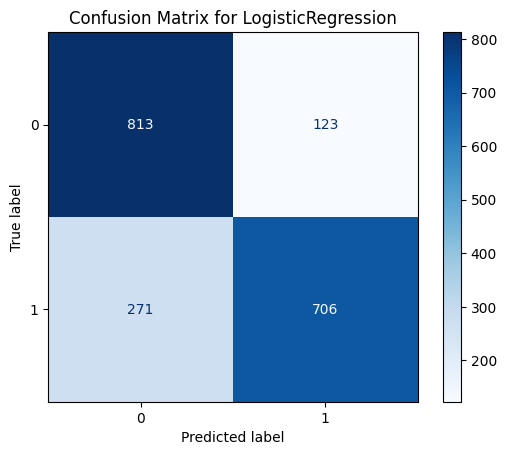

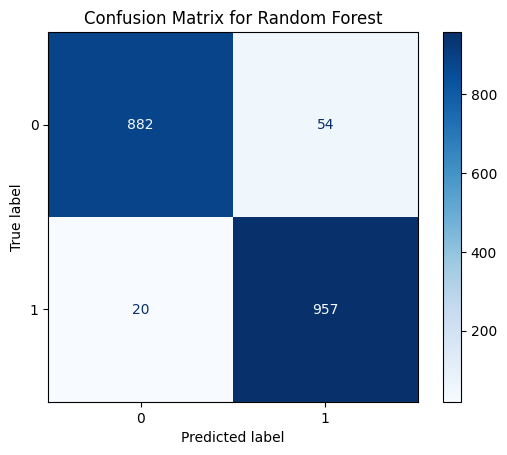

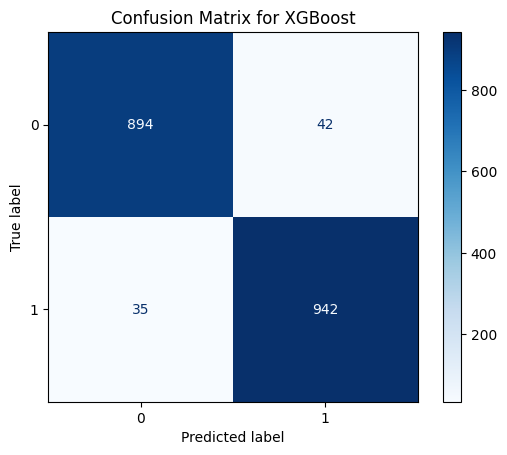

In [ ]:
# Confusion Matrix

def plot_confusion_matrix(model, x_train, y_train, x_test, y_test, model_name):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

for name, model in models.items():
    plot_confusion_matrix(model, x_train, y_train, x_test, y_test, name)

###6.3 Evaluate-ROC-AUC

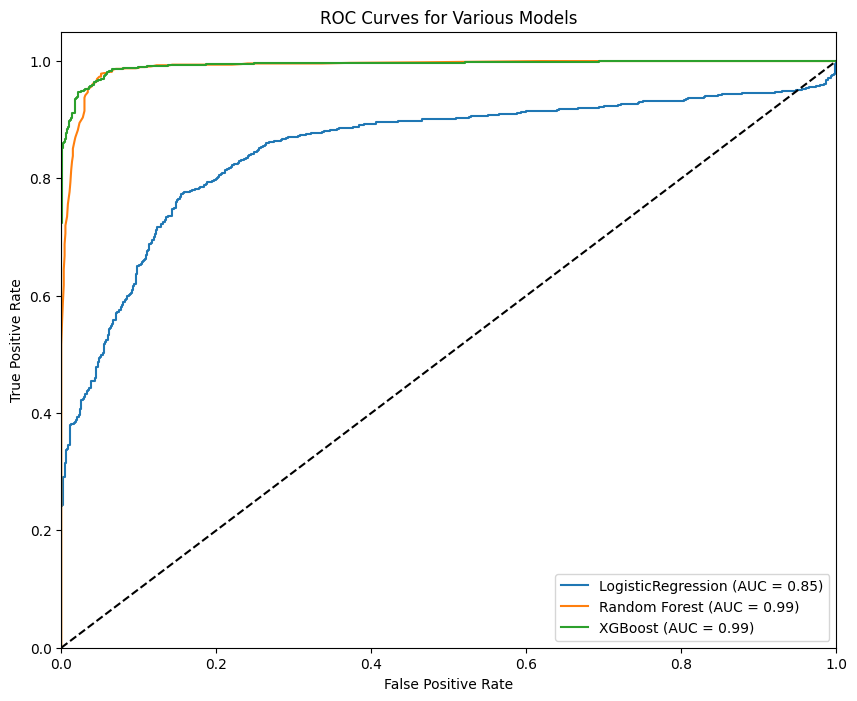

In [ ]:
def compute_roc_auc(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    probs = model.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

plt.figure(figsize=(10, 8))
for name, model in models.items():
    fpr, tpr, roc_auc = compute_roc_auc(model, x_train, y_train, x_test, y_test)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Various Models')
plt.legend(loc="lower right")
plt.show()

# 7、Deployment

In [ ]:
import sklearn
print(sklearn.__version__)

1.5.2


In [ ]:
# for deployment purpose, we will export the model which achieves the best performance.
import pickle

In [ ]:
!pip install xlsxwriter

In [ ]:
!pip install streamlit-option-menu

In [ ]:
from joblib import dump, load

# Save the model
dump(best_model_log, 'log_model.pkl')
dump(best_model_rf, 'rf_model.pkl')
dump(best_model_xgb, 'xgb_model.pkl')
print("模型已保存为 log_model.pkl, rf_model.pkl, xgb_model.pkl")

模型已保存为 log_model.pkl, rf_model.pkl, xgb_model.pkl


In [ ]:
with open("log_model.pkl", "wb") as f:
    pickle.dump(best_model_log, f)

In [ ]:
with open("rf_model.pkl", "wb") as f:
    pickle.dump(best_model_rf, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(best_model_xgb, f)

In [ ]:
!pip install streamlit -q

In [ ]:
!wget -q -O - ipv4.icanhazip.com

34.23.108.244


In [ ]:
! streamlit run abnormal_trading_detection.py & npx localtunnel --port 8501



⠙⠹⠸
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.23.108.244:8501

⠼⠴your url is: https://major-worms-brush.loca.lt
  Stopping...
^C
